https://keras.io/examples/generative/conditional_gan/ was used as a reference for the implementation of the conditional GAN.

In [1]:
# load libraries
import pickle

# imoprt data science libraries
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Import ML libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import keras
import tensorflow as tf

from keras import layers
from keras.layers import Input, Dense, Dropout, LeakyReLU, ReLU, BatchNormalization, Activation
from keras.models import Sequential

# local module with helper utils
import model_utils as mutils
from model_utils.utils import (
    imb_ratio,
    get_device,
    plot_cm,
)
from model_utils.evaluation import get_metrics, evaluate_model

In [43]:
current_k_fold = 8
SEED = current_k_fold**3
np.random.seed(SEED)

# pandas options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# deserialize pre-processed data
path_to_pickle = f"../data/kddcup/kdd_preprocessed_k{current_k_fold}.pkl"

with open(path_to_pickle, "rb") as f:
    data = pickle.load(f)
    X_train = data["X_train"]
    y_train = data["y_train"]

    X_val = data["X_val"]
    y_val = data["y_val"]

    X_test = data["X_test"]
    y_test = data["y_test"]

    col_names = data["col_names"]

print("Data loaded successfully")

# get imbalance ratio for each data set
IR_train = imb_ratio(y_train.value_counts())
IR_val = imb_ratio(y_val.value_counts())
IR_test = imb_ratio(y_test.value_counts())

# print imbalance ratios. They should be (nearly) the same. pct = 0.172 such as in the paper!
print(f"Imbalance ratio in training data: {IR_train}")
print(f"Imbalance ratio in validation data: {IR_val}")
print(f"Imbalance ratio in test data: {IR_test}")

# print number of samples in each data set
print(f"\nNumber of samples in training data: {len(y_train)}")
print(f"Number of samples in validation data: {len(y_val)}")
print(f"Number of samples in test data: {len(y_test)}")

## GAN specific pre-processing: Only use negative samples for training

X_train = X_train[y_train == 0].copy()
neg_y_train = y_train[y_train == 0].copy() # TODO: check if this is necessary

X_val = X_val[y_val == 0].copy()
neg_y_val = y_val[y_val == 0].copy()

data_dim = X_train.shape[1] # cols
latent_dim = 121

print(
	"\nX_train.shape: " , X_train.shape,
 	"\ndata_dim: ", data_dim,
 	"\nlatent_dim: ", latent_dim
)

Data loaded successfully
Imbalance ratio in training data: 4.13
Imbalance ratio in validation data: 4.13
Imbalance ratio in test data: 4.13

Number of samples in training data: 248823
Number of samples in validation data: 31103
Number of samples in test data: 31103

X_train.shape:  (200349, 121) 
data_dim:  121 
latent_dim:  121


## Generator

In [7]:
# create generator model
def get_generator(latent_dim, data_dim):
    g = Sequential(name="generator")

    g.add(
        layers.Input(shape=(latent_dim,), name="input")
    )  # input layer to receive noise from latent space
    g.add(Dense(64))
    g.add(BatchNormalization(momentum=0.8))
    g.add(LeakyReLU(negative_slope=0.2))
    g.add(layers.Dropout(0.5))

    # Hidden layer 1: Upscale to a larger feature set
    g.add(Dense(256))
    g.add(BatchNormalization(momentum=0.8))
    g.add(LeakyReLU(negative_slope=0.2))
    g.add(layers.Dropout(0.5))

    # Hidden layer 2: Continue upscaling
    g.add(Dense(512))
    g.add(BatchNormalization(momentum=0.8))
    g.add(LeakyReLU(negative_slope=0.2))
    g.add(layers.Dropout(0.5))

    g.add(Dense(data_dim, activation="tanh"))  # data_dim == cols

    return g

## Discriminator

In [8]:
# create discriminator model
def get_discriminator(data_dim):
    d = Sequential(name="discriminator")

    # Input layer
    d.add(layers.Input(shape=(data_dim,)))
    d.add(layers.Dense(128, kernel_initializer="he_uniform"))
    d.add(LeakyReLU(negative_slope=0.2))

    # Hidden layer 1
    d.add(layers.Dense(256, kernel_initializer="he_uniform"))
    d.add(layers.LeakyReLU(negative_slope=0.2))

    # Hidden layer 2
    d.add(layers.Dense(512, kernel_initializer="he_uniform"))
    d.add(layers.LeakyReLU(negative_slope=0.2))

    # Output layer: single probability score
    d.add(layers.Dense(1, activation="sigmoid"))

    # Output layer: single probability score
    d.add(layers.Dense(1, activation="sigmoid"))

    return d

## Build GAN network

In [15]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_tracker = keras.metrics.Mean(name="d_loss")
        self.g_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.seed_generator = keras.random.SeedGenerator(SEED)

    @property
    def metrics(self):
        return [self.d_loss_tracker, self.g_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_samples = data

        # Create random noise
        batch_size = tf.shape(real_samples)[0]  # Dynamically compute the batch size
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate fake samples
        fake_samples = self.generator(noise, training=True)

        # Combine fake and real samples and labels
        combined_samples = tf.concat([fake_samples, real_samples], axis=0)
       
        fake_labels = tf.zeros((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))
        labels = tf.concat([fake_labels, real_labels], axis=0)
       
        
        # Add random noise to the labels - important trick!
        # labels += 0.05 * keras.random.uniform(
        #     tf.shape(labels), seed=self.seed_generator
        # )      
        
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_samples, training=True)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # grads = [tf.clip_by_value(grad, -1.0, 1.0) for grad in grads]
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        
        # Train the generator
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1)) # Flip labels: real = fake
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(noise, training=True), training=False)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
        
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)

        return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result()
        }
    
    def test_step(self, data):
        # Unpack the data
        real_samples, real_labels = data
        batch_size = tf.shape(real_samples)[0]

        # Generate noise
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # Generate fake samples using the generator
        fake_samples = self.generator(noise, training=False)
        
        # Labels for fake samples
        fake_labels = tf.zeros((batch_size, 1))
        
        # Evaluate discriminator on real samples
        real_predictions = self.discriminator(real_samples, training=False)
        d_loss_real = self.loss_fn(real_labels, real_predictions)
        
        # Evaluate discriminator on fake samples
        fake_predictions = self.discriminator(fake_samples, training=False)
        d_loss_fake = self.loss_fn(fake_labels, fake_predictions)

        # Overall discriminator loss on test data
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        
        # Update the loss trackers
        self.d_loss_tracker.update_state(d_loss)
    
        
        return {
            "d_loss": self.d_loss_tracker.result(),
        }
    

let's test drive it

In [44]:
# create dataset
dataset = tf.data.Dataset.from_tensor_slices(X_train.astype(np.float32)) # takes 6 min, so we save it
dataset.save("../data/kddcup/gan_dataset_tensor_slices")

# load dataset
dataset = tf.data.Dataset.load("../data/kddcup/gan_dataset_tensor_slices")

# or load after saving. Slicing took 6 min
# dataset = tf.data.Dataset.load(f"../data/kddcup/vae_dataset_tensor_slices_k{current_k_fold}")

# hyperparams
epochs = 10
latent_dim = 121
batch_size = 32

batches = dataset.shuffle(buffer_size=1024).batch(batch_size)  # Batch the dataset

# build and fit GAN
discriminator = get_discriminator(data_dim)
generator = get_generator(latent_dim=latent_dim, data_dim=data_dim)

# early stopping
early_stopping_d = keras.callbacks.EarlyStopping(
    monitor="d_loss", mode="min", patience=4, restore_best_weights=True, #baseline=0.2
)

cb_ckp_save = keras.callbacks.ModelCheckpoint(f"./ckp/GAN_KDD/k_{current_k_fold}" + "epoch_{epoch}.keras")


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.compile(
    d_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
    g_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, clipvalue=1.0),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=False),
)

# let's train it
hist = gan.fit(
    batches,
    epochs=epochs,
    callbacks=[early_stopping_d, cb_ckp_save],
    validation_data=(X_val, neg_y_val),
)
# do not forget to save gan and d, g

# load gan_cc.keras
# discriminator = gan.discriminator
# discriminator = keras.models.load_model('./saved_models/GAN/gan_discriminator_kdd_1.keras')

Epoch 1/10
6261/6261 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - d_loss: 0.5086 - g_loss: 0.7659 - val_d_loss: 1.0232
Epoch 2/10
6261/6261 ━━━━━━━━━━━━━━━━━━━━ 45s 7ms/step - d_loss: 0.3809 - g_loss: 1.0841 - val_d_loss: 0.9070
Epoch 3/10
6261/6261 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - d_loss: 0.2932 - g_loss: 1.3616 - val_d_loss: 0.9358
Epoch 4/10
6261/6261 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - d_loss: 0.2261 - g_loss: 1.5959 - val_d_loss: 1.0158
Epoch 5/10
6261/6261 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - d_loss: 0.1739 - g_loss: 1.8343 - val_d_loss: 1.1195
Epoch 6/10
6261/6261 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - d_loss: 0.1336 - g_loss: 2.0814 - val_d_loss: 1.2725
Epoch 7/10
6261/6261 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - d_loss: 0.1029 - g_loss: 2.3335 - val_d_loss: 1.3696
Epoch 8/10
6261/6261 ━━━━━━━━━━━━━━━━━━━━ 65s 10ms/step - d_loss: 0.0796 - g_loss: 2.5880 - val_d_loss: 1.5427
Epoch 9/10
6261/6261 ━━━━━━━━━━━━━━━━━━━━ 58s 9ms/step - d_loss: 0.0623 - g_loss: 2.8414 - val_d_loss: 1.7242
Epoch 10/

In [ ]:
# getting best epoch 
metric_history = hist.history["val_d_loss"]
best_epoch = metric_history.index(min(metric_history)) + 1
print("Best epoch: ", best_epoch, "Best Value: ", min(metric_history))

# best_epoch=42
gan.load_weights(f"./ckp/GAN_KDD/k_{current_k_fold}epoch_{best_epoch}.keras")

# Continuous scores from the discriminator
anomalous_scores = discriminator.predict(X_test[y_test == 1], verbose=0)
normal_scores = discriminator.predict(X_test[y_test == 0], verbose=0)

# True labels
y_true = np.concatenate([np.ones_like(anomalous_scores), np.zeros_like(normal_scores)])
scores = np.concatenate([anomalous_scores, normal_scores])

best_metric = 0.
best_th = 0.

for threshold in np.arange(0.1, 1, 0.001):
    current_metric = get_metrics(y_true, scores.flatten(), op="<", threshold=threshold)["AUCPRC"]
    if current_metric > best_metric:
        best_metric = current_metric
        best_th = threshold

print("Best Metric Score:", best_metric)
print("Best Threshold: ", best_th)

print(f"metrics for k-fold {current_k_fold}:")
get_metrics(y_true, scores.flatten(), op="<", threshold=best_th)

In [29]:
# # # save model
# gan.save('./saved_models/GAN/gan_kdd_1.keras')
# discriminator.save('./saved_models/GAN/gan_discriminator_kdd_1.keras')
# generator.save('./saved_models/GAN/gan_generator_kdd_1.keras')

In [74]:
# gan.load_weights(f'./ckp/GAN_KDD/epoch_{8}.keras')

print("Mean score anomalous data: ", gan.discriminator.predict(X_test[y_test == 1], verbose=0).mean())
print("Mean score normal data: ", gan.discriminator.predict(X_test[y_test == 0], verbose=0).mean())

Mean score anomalous data:  0.59455806
Mean score normal data:  0.60799533


190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
783/783 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step


<Axes: title={'center': 'Normal'}, ylabel='Frequency'>

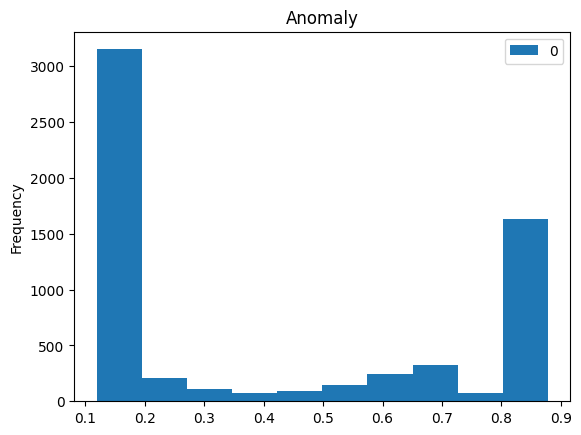

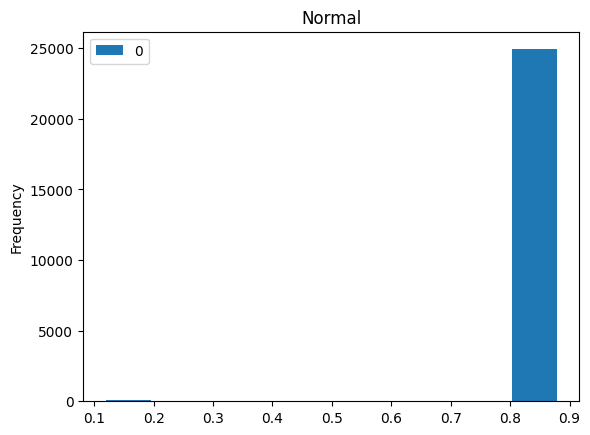

In [61]:
anomalies = X_test[y_test == 1]
normals = X_test[y_test == 0]

pred_anomalies = pd.DataFrame(discriminator.predict(anomalies))
pred_normals = pd.DataFrame(discriminator.predict(normals))

pred_anomalies.plot(kind='hist', bins=10, title='Anomaly')
pred_normals.plot(kind='hist', bins=10, title='Normal')
# pred_anomalies.plot(kind='box', title='Anomaly')
# pred_normals.plot(kind='box', title='Normal')

# pred_anomalies = pred_anomalies.map(lambda x: 1 if x < 0.5 else 0)
# pred_normals = pred_normals.map(lambda x: 0 if x > 0.5 else 1)


In [72]:
# Continuous scores from the discriminator
anomalous_scores = discriminator.predict(X_test[y_test == 1], verbose=0)
normal_scores = discriminator.predict(X_test[y_test == 0], verbose=0)

# True labels
y_true = np.concatenate([np.ones_like(anomalous_scores), np.zeros_like(normal_scores)])
scores = np.concatenate([anomalous_scores, normal_scores])

In [ ]:
best_metric = 0.
best_th = 0.

for threshold in np.arange(0.1, 1, 0.001):
    current_metric = get_metrics(y_true, scores, op="<", threshold=threshold)["AUCPRC"]
    if current_metric > best_metric:
        best_metric = current_metric
        best_th = threshold

print("Best Metric Score:", best_metric) # best: 0.8770000000000007
print("Best Threshold: ", best_th)

In [ ]:
get_metrics(y_true, scores, op="<", threshold=0.8770000000000007)

In [ ]:
# save the gan model weights
# gan.save_weights('./saved_models/GAN/gan_kdd_1.weights.h5')
# print('Model saved.')

# code to restore 
# build and fit GAN
# discriminator2 = get_discriminator(data_dim)
# generator2 = get_generator(latent_dim=latent_dim, data_dim=data_dim)

# gan2 = GAN(discriminator=discriminator2, generator=generator2, latent_dim=latent_dim)

# gan2.compile(
#     d_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
#     g_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, clipvalue=1.0),
#     loss_fn=keras.losses.BinaryCrossentropy(from_logits=False),
# )

# gan2.load_weights('./saved_models/GAN/gan_kdd_1.weights.h5')
